# House Prices: on the top with a simple model

Please, upvote if you find useful.

### Steps:
* 1- Preprocessing and exploring
    * 1.1 - Imports
    * 1.2 - Checking Types
    * 1.3 - Missing Values
    * 1.4 - Remove some features high correlated and outliers
    * 1.5 - Transformations
    * 1.6 - Prepare for model
* 2- Model
* 3- Submission


### 1.1- Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.special import boxcox1p
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso, LassoCV

In [2]:
train=pd.read_csv("~/Datas/KaggleHouse/train.csv")
test=pd.read_csv("~/Datas/KaggleHouse/test.csv")
test2=pd.read_csv("~/Datas/KaggleHouse/test.csv")
len_train=train.shape[0]
houses=pd.concat([train,test], sort=False)
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


### 1.2- Checking Types


In [3]:
houses.select_dtypes(include='object').head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [4]:
houses.select_dtypes(include=['float','int']).head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,61,0,0,0,0,0,2,2008,208500.0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,298,0,0,0,0,0,0,5,2007,181500.0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,0,42,0,0,0,0,0,9,2008,223500.0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,0,35,272,0,0,0,0,2,2006,140000.0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,192,84,0,0,0,0,0,12,2008,250000.0


#### When we read the data description file we realize that "MSSubClass", a numerical features (not ordinal), should be transformed into categorical. I'll do this later in this kernel.

### 1.3 - Missing Values

### Categorical


In [5]:
houses.select_dtypes(include='object').isnull().sum()[houses.select_dtypes(include='object').isnull().sum()>0]

MSZoning           4
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Electrical         1
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageFinish     159
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

Depending on the categorical variable, missing value can means "None" (which I will fill with "None") or "Not Available" (which I will fill with the mode).

In [6]:
for col in ('Alley','Utilities','MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
            'BsmtFinType2','Electrical','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
           'PoolQC','Fence','MiscFeature'):
    train[col]=train[col].fillna('None')
    test[col]=test[col].fillna('None')


In [7]:
#for col in ('MSZoning','Exterior1st','Exterior2nd','KitchenQual','SaleType','Functional'):
    #train[col]=train[col].fillna(train[col].mode()[0])
    #test[col]=test[col].fillna(test[col].mode()[0])

In [8]:
for col in ('MSZoning','Exterior1st','Exterior2nd','KitchenQual','SaleType','Functional'):
    train[col]=train[col].fillna(train[col].mode()[0])
    test[col]=test[col].fillna(train[col].mode()[0])

### Numerical

In [9]:
houses.select_dtypes(include=['int','float']).isnull().sum()[houses.select_dtypes(include=['int','float']).isnull().sum()>0]

LotFrontage      486
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
GarageYrBlt      159
GarageCars         1
GarageArea         1
SalePrice       1459
dtype: int64

Some NAs means "None" (which I will fill with 0) or means "Not Available" (which I will fill with mean)

In [10]:
for col in ('MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','GarageYrBlt','GarageCars','GarageArea'):
    train[col]=train[col].fillna(0)
    test[col]=test[col].fillna(0)

In [11]:
#train['LotFrontage']=train.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.mean()))
#test['LotFrontage']=test.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.mean()))

In [12]:
train['LotFrontage']=train['LotFrontage'].fillna(train['LotFrontage'].mean())
test['LotFrontage']=test['LotFrontage'].fillna(train['LotFrontage'].mean())



In [13]:
print(train.isnull().sum().sum())
print(train.isnull().sum().sum())

0
0


### 1.4 - Remove some features high correlated and outliers

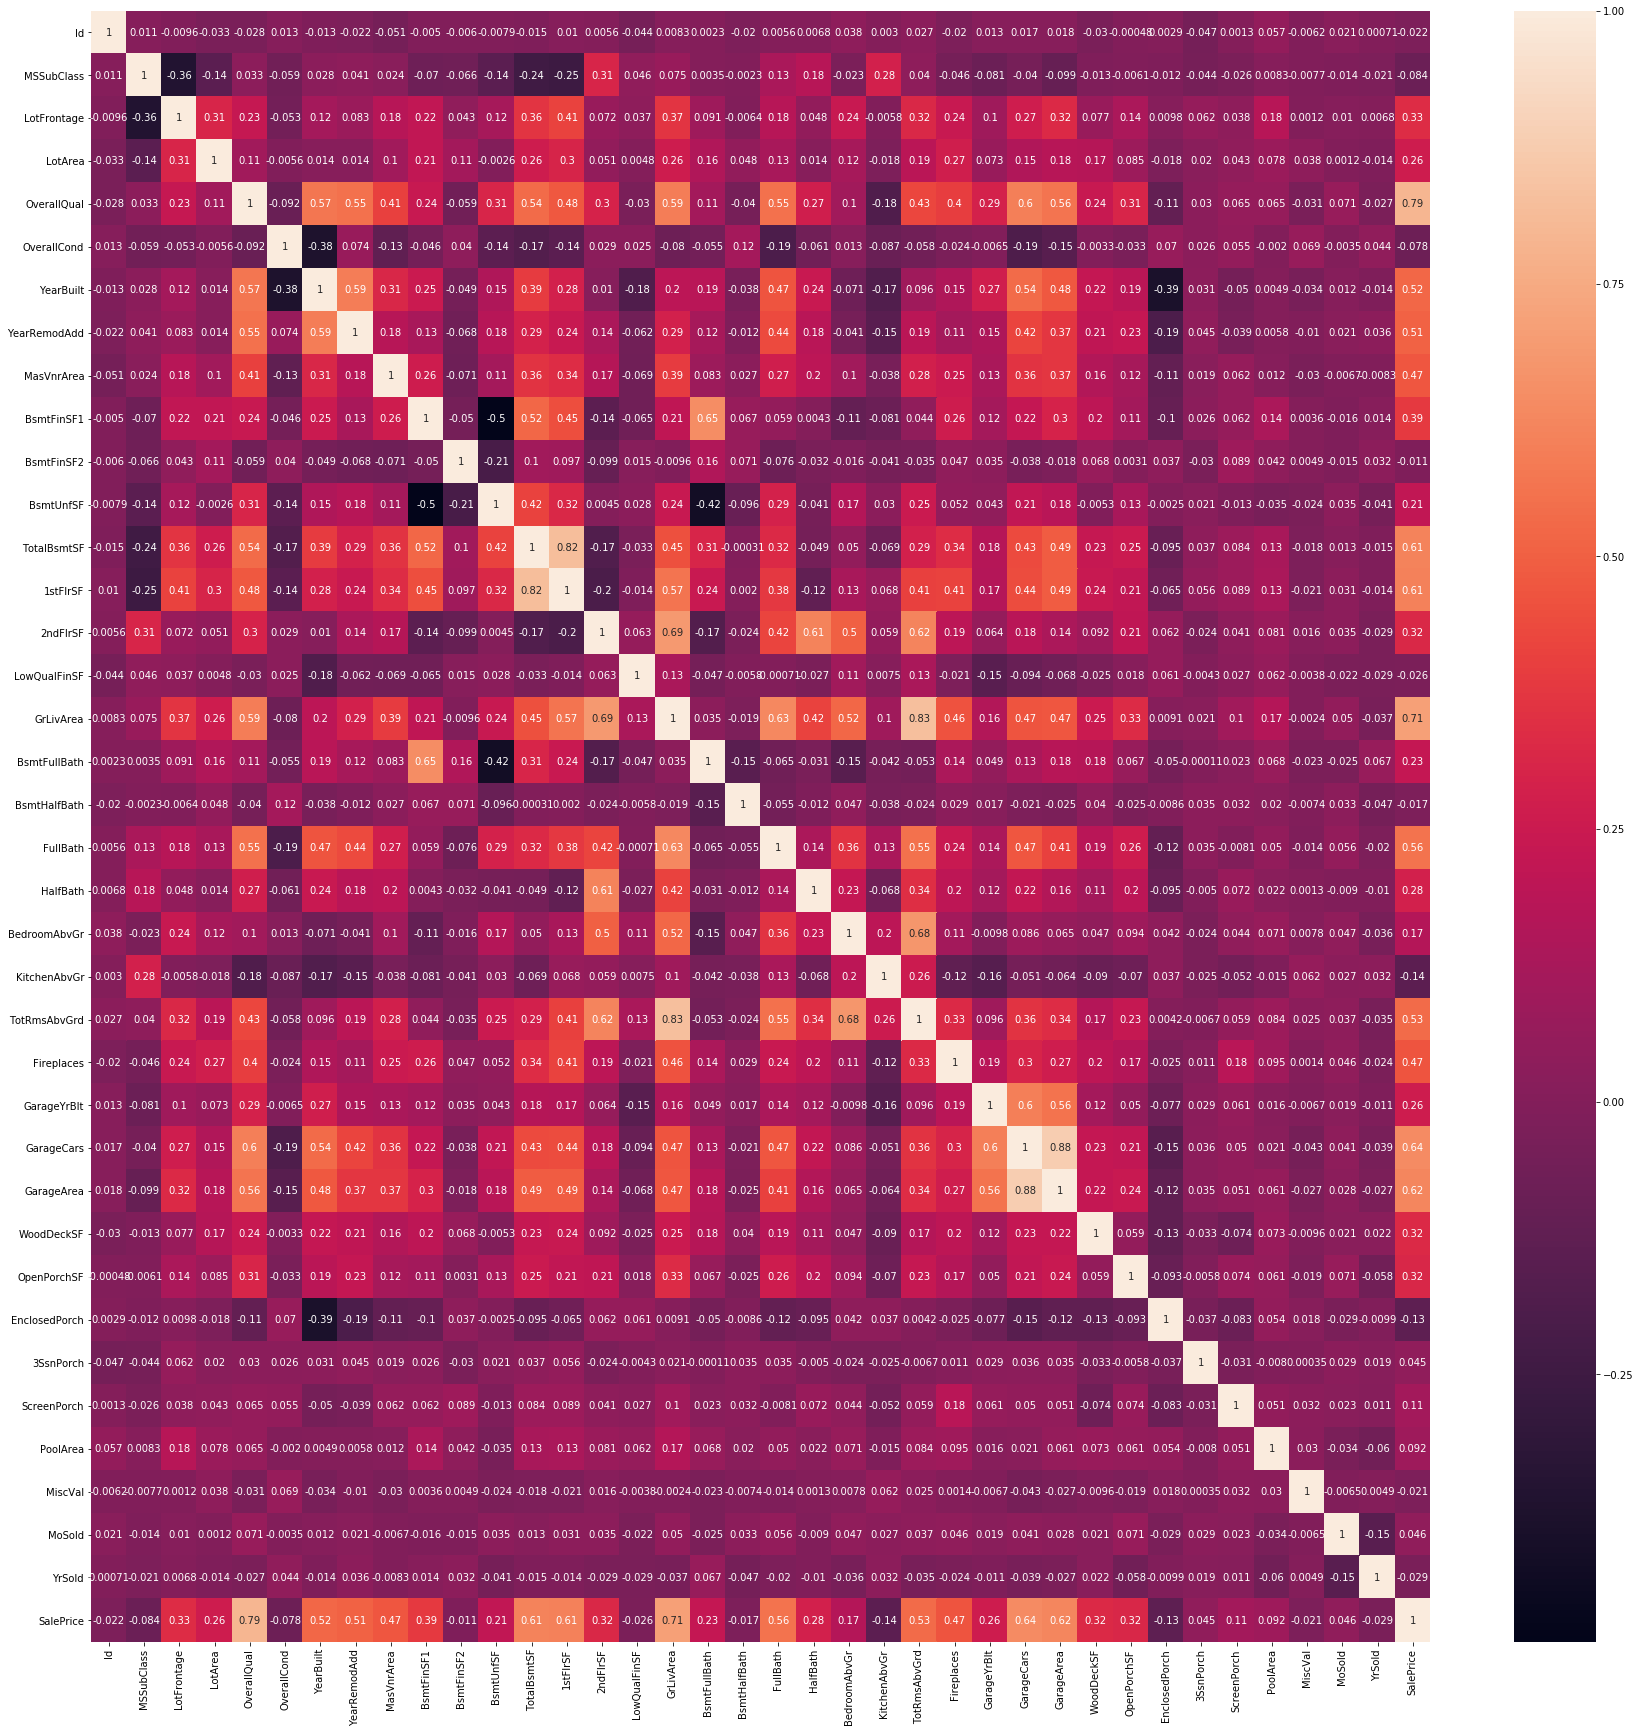

In [14]:
plt.figure(figsize=[30,30])
sns.heatmap(train.corr(), annot=True)

In [15]:
#from 2 features high correlated, removing the less correlated with SalePrice
train.drop(['GarageArea','1stFlrSF','TotRmsAbvGrd','2ndFlrSF'], axis=1, inplace=True)
test.drop(['GarageArea','1stFlrSF','TotRmsAbvGrd','2ndFlrSF'], axis=1, inplace=True)

In [16]:
#removing outliers recomended by author
train = train[train['GrLivArea']<4000]

In [17]:
len_train=train.shape[0]
print(train.shape)

(1456, 77)


In [18]:
houses=pd.concat([train,test], sort=False)

### 1.5 - Transformations

Numerical to categorical

In [19]:
houses['MSSubClass']=houses['MSSubClass'].astype(str)

Skew

In [20]:
skew=houses.select_dtypes(include=['int','float']).apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skew_df=pd.DataFrame({'Skew':skew})
skewed_df=skew_df[(skew_df['Skew']>0.5)|(skew_df['Skew']<-0.5)]

In [21]:
skewed_df.index

Index(['MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
       'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch',
       'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'SalePrice',
       'LotFrontage', 'GrLivArea', 'BsmtFinSF1', 'BsmtUnfSF', 'Fireplaces',
       'HalfBath', 'TotalBsmtSF', 'BsmtFullBath', 'OverallCond', 'YearBuilt',
       'GarageYrBlt'],
      dtype='object')

In [22]:
train=houses[:len_train]
test=houses[len_train:]

In [23]:
lam=0.1
for col in ('MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
       'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch',
       'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF',
       'LotFrontage', 'GrLivArea', 'BsmtFinSF1', 'BsmtUnfSF', 'Fireplaces',
       'HalfBath', 'TotalBsmtSF', 'BsmtFullBath', 'OverallCond', 'YearBuilt',
       'GarageYrBlt'):
    train[col]=boxcox1p(train[col],lam)
    test[col]=boxcox1p(test[col],lam)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [24]:
train['SalePrice']=np.log(train['SalePrice'])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Categorical to one hot encoding

In [25]:
houses=pd.concat([train,test], sort=False)
houses=pd.get_dummies(houses)

### 1.6 - Prepare for model


In [26]:
train=houses[:len_train]
test=houses[len_train:]

In [27]:
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [28]:
x=train.drop('SalePrice', axis=1)
y=train['SalePrice']
test=test.drop('SalePrice', axis=1)

In [29]:
sc=RobustScaler()
x=sc.fit_transform(x)
test=sc.transform(test)

In [31]:
# x.to_csv(r'~/Datas/KaggleHouse/X_train_BetterPrep.csv',index = False)
# y.to_csv(r'~/Datas/KaggleHouse/Y_train_BetterPrep.csv',index = False)
# test.to_csv(r'~/Datas/KaggleHouse/X_test_BetterPrep.csv',index = False)

# 2 - Model

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, shuffle=True)

In [57]:
model = []
cnt = 0
for a in [0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05]:
    for warm_start  in [True,False]:
        model.append(Lasso(alpha = a, random_state=1,warm_start  = warm_start  ))
        model[cnt].fit(X_train,y_train)
        y_pred = model[cnt].predict(X_test)
        mse = mean_squared_error(np.exp(y_test),np.exp(y_pred))
        rmse = np.sqrt(mse)
        print("Root Mean Squared Error: {} for {} A and {}".format(rmse,a,warm_start  ))
        cnt+=1

Root Mean Squared Error: 24161.552235785162 for 5e-05 A and True
Root Mean Squared Error: 24161.552235785162 for 5e-05 A and False
Root Mean Squared Error: 22917.916404128737 for 0.0001 A and True
Root Mean Squared Error: 22917.916404128737 for 0.0001 A and False
Root Mean Squared Error: 22615.249618386963 for 0.0005 A and True
Root Mean Squared Error: 22615.249618386963 for 0.0005 A and False
Root Mean Squared Error: 23794.93112568556 for 0.001 A and True
Root Mean Squared Error: 23794.93112568556 for 0.001 A and False
Root Mean Squared Error: 28541.522554701045 for 0.005 A and True
Root Mean Squared Error: 28541.522554701045 for 0.005 A and False
Root Mean Squared Error: 31634.937807576986 for 0.01 A and True
Root Mean Squared Error: 31634.937807576986 for 0.01 A and False
Root Mean Squared Error: 43534.44790389367 for 0.05 A and True
Root Mean Squared Error: 43534.44790389367 for 0.05 A and False


In [58]:
# alpha = 0.0005
# fit_intercept = True
# normalize = False
best_model = Lasso(alpha = 0.0005, fit_intercept = True, normalize = False)
best_model.fit(x,y)

Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

##     Custom Model

In [47]:
def polyFeat(arr,deg):
    polynomial_features = PolynomialFeatures(degree=deg)
    return polynomial_features.fit_transform(arr)

In [55]:
modelLinear = []
for deg in range(3):
    X_train_poly = polyFeat(X_train,deg)
    X_test_poly = polyFeat(X_test,deg)
    modelLinear = LinearRegression()
    reg = modelLinear.fit(X_train_poly, y_train)
    y_poly_pred = modelLinear.predict(X_test_poly)
    mse = mean_squared_error(np.exp(y_test),np.exp(y_poly_pred))
    rmse = np.sqrt(mse)
    print("Root Mean Squared Error: {} for {} Degree".format(rmse,deg))

Root Mean Squared Error: 77244.95966436734 for 0 Degree
Root Mean Squared Error: 23620.28321451506 for 1 Degree
Root Mean Squared Error: 44892.65299220254 for 2 Degree


In [59]:
X_poly = polyFeat(x,1)
modelLinearFin = LinearRegression()
reg = modelLinear.fit(X_poly, y)

# 3- Submission

In [60]:
# pred=model.predict(test)
# X_test_poly = polyFeat(test,1)
pred = best_model.predict(test)
# pred=reg.predict(X_test_poly)
preds=np.exp(pred)

In [61]:
output=pd.DataFrame({'Id':test2.Id, 'SalePrice':preds})
output.to_csv(r'~/Datas/KaggleHouse/Lasso_hypTurned.csv', index=False)

In [62]:
output.head()

,Id,SalePrice
0,1461,118291.099008
1,1462,152264.839338
2,1463,181148.196657
3,1464,195955.795029
4,1465,196802.726144
